In [358]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

In [359]:
dataset = pd.read_csv('C:/Users/diana/Desktop/proiect test/energy_client/client_1.csv')
dataset = dataset.drop(columns=['Data Start Time', 'Meter No.'])
dataset['Data End Time'] = pd.to_datetime(dataset['Data End Time'], format='%Y-%m-%d %H:%M:%S')
dataset = dataset.set_index('Data End Time')
dataset = dataset.sort_index()
dataset = dataset.asfreq('15min')
dataset = dataset.rename(columns={'Active energy import A+(1.8.0)': 'Demand'})
dataset.tail()

,Demand
Data End Time,
2023-05-21 23:00:00,0.231
2023-05-21 23:15:00,0.231
2023-05-21 23:30:00,0.235
2023-05-21 23:45:00,0.234
2023-05-22 00:00:00,0.229


In [360]:
energy = dataset[['Demand']]

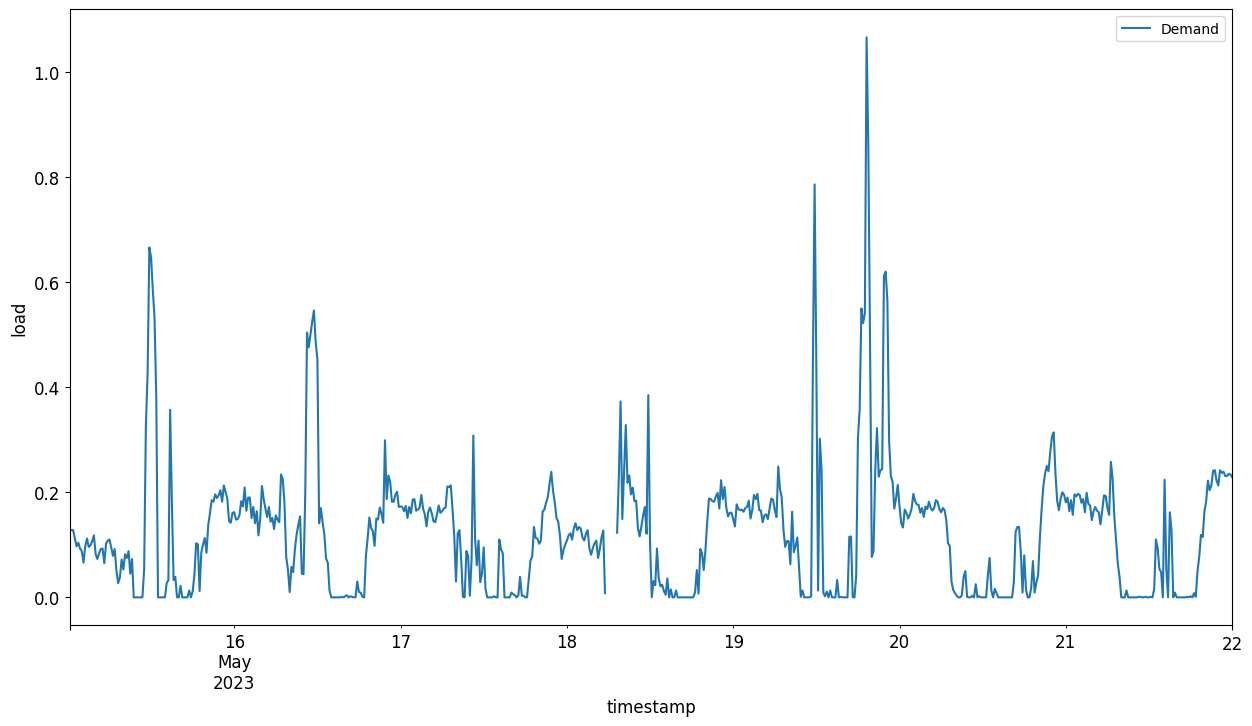

In [361]:
energy.plot(y='Demand', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [362]:
train_start_dt = '2023-05-15 00:15:00'
test_start_dt = '2023-05-20 12:00:00'

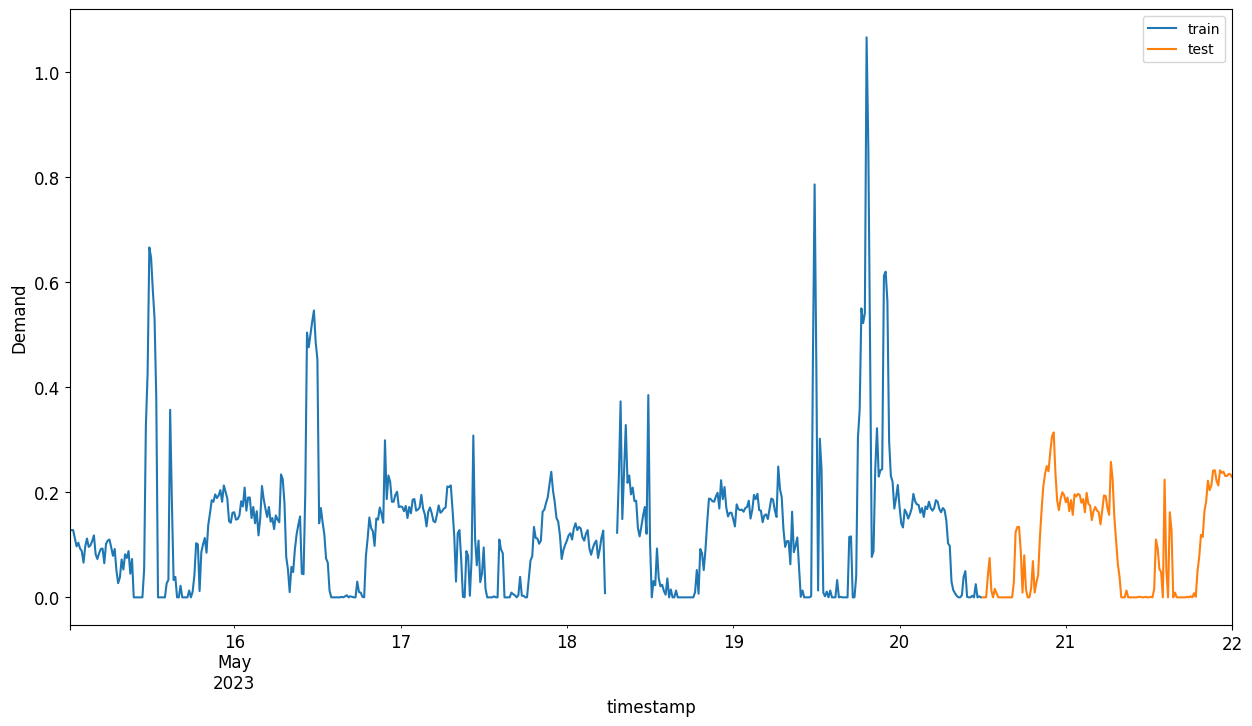

In [363]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['Demand']].rename(columns={'Demand':'train'}) \
    .join(energy[test_start_dt:][['Demand']].rename(columns={'Demand':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('Demand', fontsize=12)
plt.show()

In [364]:
# check how many null values
dataset.isnull().values.sum()
dataset = dataset.interpolate()

In [365]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['Demand']]
test = energy.copy()[energy.index >= test_start_dt][['Demand']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (527, 1)
Test data shape:  (145, 1)


In [366]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)

In [367]:
test['load'] = scaler.transform(test)

In [368]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values

timesteps=5

train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(523, 5)

In [369]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(141, 5)

In [370]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(523, 4) (523, 1)
(141, 4) (141, 1)


In [371]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
y_train = imputer.fit_transform(y_train)

model = SVR(kernel='rbf',gamma=0.7, C=60, epsilon = 0.07)
model.fit(x_train, y_train[:,0])
SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.05, gamma=0.5,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

SVR(C=10, epsilon=0.05, gamma=0.5)

In [372]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(523, 1) (141, 1)


In [373]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

523 141


In [374]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

523 141


In [375]:
train_timestamps = energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = energy[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

523 141


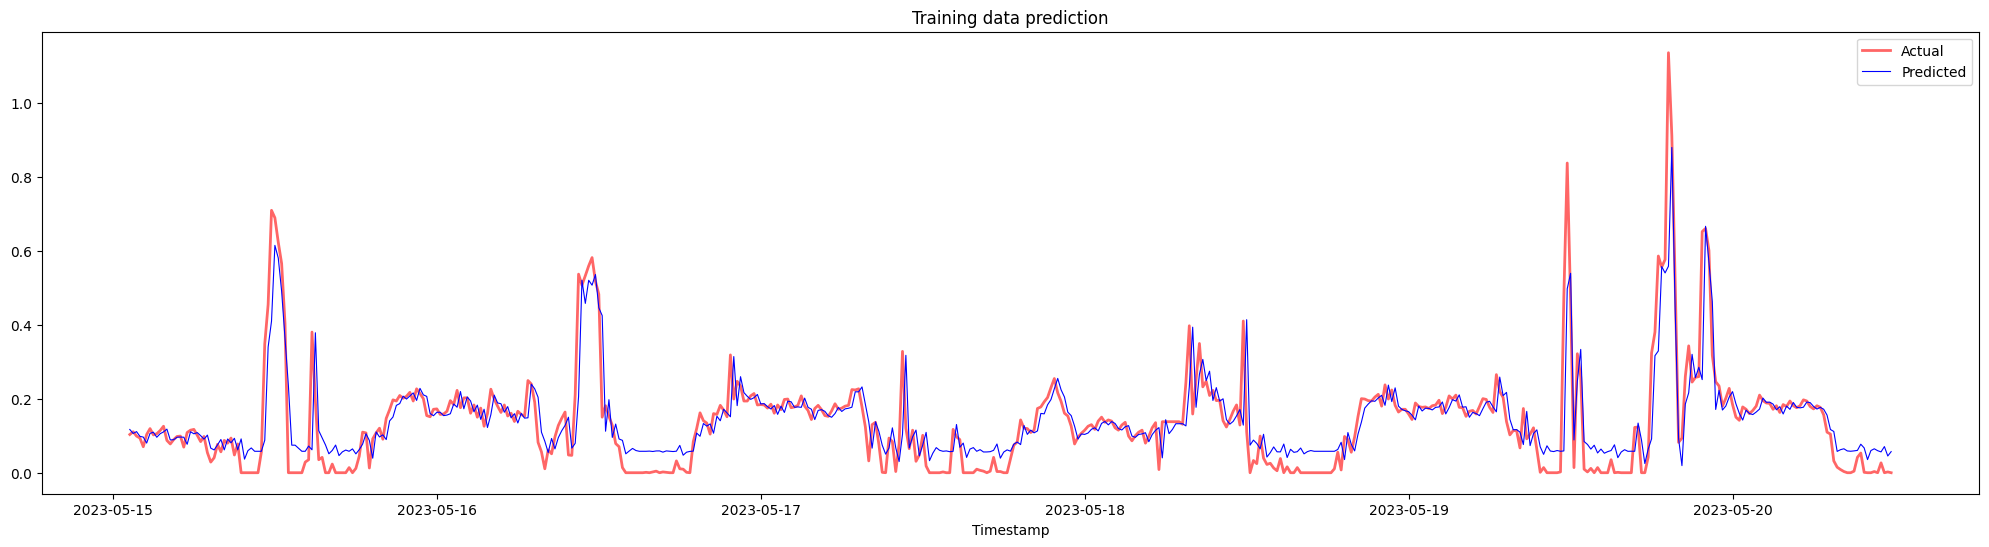

In [376]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [377]:
print('MAPE for training data: ', mean_absolute_percentage_error(y_train_pred, y_train)*100, '%')

MAPE for training data:  45.56795139860786 %


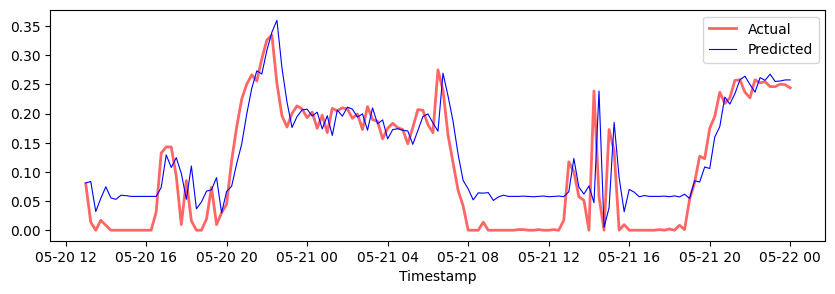

In [378]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [379]:
print('MAPE for testing data: ', mean_absolute_percentage_error(y_test_pred, y_test)*100, '%')

MAPE for testing data:  54.240574429428456 %
